In [1]:
import glob
import logging
import os
from collections import OrderedDict
from pathlib import Path

import cartopy.crs as ccrs
import folium
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray
from lightning import get_obsgdf, ztfs
from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon
from statisticplot import make_map, stat_plots
from tqdm import tqdm

import G211
%matplotlib inline
from ml_functions import (
    get_args,
    get_savedmodel_path,
    load_df,
    load_model,
    predct2,
)
from spc import (
    convective_outlook_colors,
    enhtstm_colors,
    get_issuance_time,
    get_outlooks,
)

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

2024-02-19 15:18:21.570055: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 15:18:23.133949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# color map for SPC outlook
convective_outlook_colors
# color map for SPC enhanced tstm outlook
enhtstm_colors.update({0: "white"})
enhtstm_colors = OrderedDict(enhtstm_colors)
enhtstm_colors.move_to_end(0, last=False)
enhtstm_cmap = ListedColormap(list(enhtstm_colors.values()), name="tstm outlook")

cmap = "pink_r"

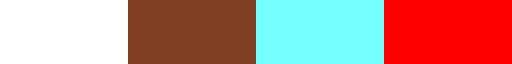

In [3]:
enhtstm_cmap

In [4]:
# map projection
map_crs = G211.g211
grid = G211.grid
conus_mask = G211.mask

In [5]:
def shp2ds(gs, issue, valid_start_hour, valid_end_hour):
    """
    convert geopandas dataframe to xarray dataset
    """
    df = conus_mask.to_dataframe(name="conus").join(
        gs.drop(columns="geometry").sort_index()
    )
    da = []
    for c in df.columns:
        da.append(xarray.DataArray(df[c].unstack("x").values, name=c, dims=["y", "x"]))
    ds = xarray.merge(da)
    ds["issue"] = issue
    ds["valid_start_hour"] = valid_start_hour
    ds["valid_end_hour"] = valid_end_hour
    return ds

### Load SPC enhanced tstm outlook

In [6]:
# downloaded by get_enhtstm.ipynb
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
bad_file = (
    tmpdir / "enhtstm/2020/enh12_20200215_150400_202002150222-shp.zip"
)  # incomplete
assert bad_file not in sfiles

for ifile in tqdm(sfiles):
    ofile = ifile.with_suffix(".nc")
    if os.path.exists(ofile):
        continue
    gs = geopandas.read_file(ifile)

    issue, valid_start, valid_end = get_issuance_time(ifile)

    gs = grid.to_crs(gs.crs).sjoin(gs, how="inner", rsuffix="poly")
    # convert shapes to grid
    ds = shp2ds(gs, issue, valid_start.hour, valid_end.hour)
    print(ofile)
    ds.to_netcdf(ofile)

100%|██████████| 15425/15425 [00:26<00:00, 575.19it/s] 


In [7]:
# SPC convective outlooks
convoutlook = False
if convoutlook:
    agdf = get_outlooks()
    agdf.head(170).tail()

    # examples of SPC issuances with a particular risk threshold
    risk = "ENH"
    ih = agdf["THRESHOLD"] == risk
    print(f"{sum(ih)} {risk} risk days")
    c = agdf.loc[ih].sort_values("PRODISS").PRODISS.values
    print(c[20::100])

In [8]:
m = tmpdir.glob("enhtstm/2021/enh00_20210722_222000_2021072*-shp.zip")
list(m)[1]

PosixPath('/glade/derecho/scratch/ahijevyc/tmp/enhtstm/2021/enh00_20210722_222000_202107221551-shp.zip')

In [9]:
ifile = sfiles[5098]
# ifile = sfiles[4853]
# ifile = tmpdir / "enhtstm/2021/enh20_20210721_211600_202107210450-shp.zip"
gs = geopandas.read_file(ifile)
issue, valid_start, valid_end = get_issuance_time(ifile)


# Experimental: instead of setting NaNs to zero after sjoin and converting to int,
# avoid NaNs by adding a "zeros" GeoDataFrame with DN = 0 for all area
# outside enhanced tstm polygons. Is it cleaner? Perhaps not.
# Define global geometry
global_geom = Polygon([(-180, -90), (-180, 89), (180, 89), (180, -90)])
# Set DN = 0 in global geometry.
zeros = geopandas.GeoDataFrame(
    {"DN": [0], "geometry": global_geom},
    crs="EPSG:4326",
)
# subtract gs area
zeros = zeros.overlay(gs.to_crs("EPSG:4326"), how="difference")
# Combine zeros area with gs.
gs = pd.concat([gs.to_crs(zeros.crs), zeros]).reset_index(drop=True)
# Assign value to grid points within polygons
gs = (
    grid[conus_mask.values.ravel()].to_crs(gs.crs).sjoin(gs, how="left", rsuffix="poly")
)
gs["issue"] = issue
# convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
gs["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
gs["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
issue, valid_start, valid_end

('1300',
 datetime.datetime(2021, 7, 22, 20, 0),
 datetime.datetime(2021, 7, 23, 0, 0))

In [10]:
if convoutlook:
    import requests

    # Choose a particular convective outlook, grab issue time and expire time
    prodiss = "201803261955"
    issue = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].ISSUE.iloc[0])
    expire = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].EXPIRE.iloc[0])

    if issue < pd.to_datetime("20221128"):
        column = "THRESHOLD"
        subset = agdf["DAY"].eq(1) & agdf["CATEGORY"].eq("CATEGORICAL")
        subset = subset & agdf["PRODISS"].eq(prodiss)
        gdf = agdf[subset]
    else:
        ifile = requests.get(
            "https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson"
        )
        gdf = geopandas.GeoDataFrame.from_features(ifile.json())
        gdf = gdf.set_crs("epsg:4269")
        column = "LABEL"
    gdf

    if False:
        # Subtract higher thresholds from lower thresholds so they don't overlap
        cat = "TSTM"
        for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
            logging.debug(f"subtracting {subtract}")
            gdf.loc[gdf[column].eq(cat)] = (
                gdf.loc[gdf[column].eq(cat)]
                .overlay(gdf[gdf[column].eq(subtract)], how="difference")
                .values
            )
            cat = subtract
            if subtract not in gdf[column]:
                break

In [11]:
spc_fcst = gs.to_crs(ccrs.PlateCarree())
column = "DN"
obsvar = "cg.ic"
o_thresh = 1
twin = 4
rptdist = 20


args = get_args(o_thresh, twin)

setattr(args, "idate", pd.to_datetime(valid_start).floor("1D"))
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=Timestamp('2021-07-22 00:00:00'), ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2020-12-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=4, suite='default')

In [12]:
obsgdf = get_obsgdf(args, valid_start, valid_end, obsvar, rptdist)

2024-02-19 15:41:37,342 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021072200-0000.par 0.1G mtime Sat Dec 16 10:59:13 2023 240 features 8 labels and 4 index_cols & dropna.


In [13]:
import folium.plugins

m = folium.plugins.DualMap(location=[40, -95], zoom_start=3)
# 40-km rptdist
get_obsgdf(args, valid_start, valid_end, obsvar, 40).explore(
    m=m.m1, column=obsvar, name="40", cmap="pink_r",
)
# 20-km rptdist
obsgdf.explore(m=m.m2, column=obsvar, cmap="pink_r",)

2024-02-19 15:41:39,813 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021072200-0000.par 0.1G mtime Sat Dec 16 10:59:13 2023 240 features 8 labels and 4 index_cols & dropna.


In [14]:
m = spc_fcst.explore(
    column=column,
    categories=sorted(spc_fcst[column].unique().tolist()),
    cmap=enhtstm_cmap,
    name="DN",
    marker_kwds=dict(radius=4),
)
obsgdf[obsgdf[obsvar] >= o_thresh].explore(
    m=m, marker_kwds=dict(color="yellow", fill=False), name=f"{obsvar} ≥ {o_thresh}"
)
folium.LayerControl().add_to(m)
m

In [15]:
# MOS LAMP lightning forecast
LAMP = False
if LAMP:
    from awips.dataaccess import DataAccessLayer

    DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("grid")
    request.setLocationNames("LAMP2p5")
    request.setParameters("PROLGHT2hr")
    # request.setLevels("2.0FHAG")

    # Take a look at our request
    logging.info(request)

    grid_locations = DataAccessLayer.getAvailableLevels(request)
    grid_locations.sort()
    list(grid_locations)

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

    # Get the most recent grid data
    response = DataAccessLayer.getGridData(request, [fcstRun[0]])

    logging.info(f"{len(times)} available times {len(fcstRun)} forecast runs")

    grid = response[0]
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    data[data == -999999] = np.nan
    data.min()
    np.nanmin(data)

    fig, ax = make_map(bbox=bbox, projection=map_crs)
    cs = ax.pcolormesh(lons, lats, data, cmap=cmap, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, shrink=0.7, orientation="horizontal")
    cbar.set_label(
        grid.getLocationName()
        + " "
        + grid.getLevel()
        + " "
        + grid.getParameter()
        + " ("
        + grid.getUnit()
        + ") "
        + "valid "
        + str(grid.getDataTime().getRefTime())
    )

    fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
    cs2 = ax2.contour(
        lons,
        lats,
        data,
        80,
        cmap=cmap,
        levels=6,
        transform=ccrs.PlateCarree(),
        vmin=np.nanmin(data),
        vmax=np.nanmax(data),
    )
    cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation="horizontal")
    cbar2.set_label(
        grid.getLocationName()
        + " "
        + grid.getLevel()
        + " "
        + grid.getParameter()
        + " ("
        + grid.getUnit()
        + ") "
        + "valid "
        + str(grid.getDataTime().getRefTime())
    )

## Define observation numpy array, geodataframe, thresholds

In [16]:
# simple 1-D numpy array of observations for verification
obs = obsgdf.set_index(["x", "y"])[obsvar]

# drop nans outside CONUS (mask applied earlier)
obs = obs[~np.isnan(obs)]

# truncate observation geodataframe based on event threshold (used for plots)
o = obsgdf[obsgdf[obsvar] >= o_thresh]

# Alternative event thresholds for observations (evenly spaced logrithmically)
thresh = np.round(np.logspace(0, 3, 16), decimals=0).astype(int)
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")

### Verify SPC enhanced tstm forecast

In [17]:
fcst = spc_fcst
# so we can apply 6045-element mask
fcst = fcst.merge(grid, on=["x", "y"], how="right")
fcst = fcst.DN / 100
# Drop values outside CONUS
fcst = fcst[conus_mask.data.ravel()]
# Assign 0 to points outside forecast polygons
fcst[np.isnan(fcst)] = 0
fcst.name = "SPC"

pthresh = pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0

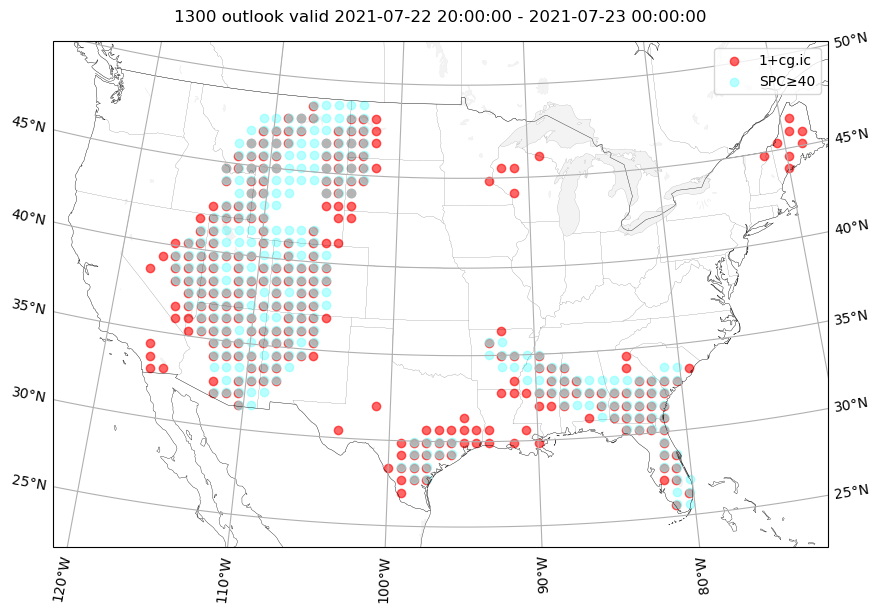

In [18]:
sns.reset_defaults()
fig, ax = make_map()
f_thresh = 40
assert f_thresh in [10, 40, 70]
ax.set_title(f"{issue} outlook valid {valid_start} - {valid_end}")
o.plot(
    color="red",
    alpha=0.6,
    ax=ax,
    transform=ccrs.PlateCarree(),
    label=f"{o_thresh}+{obsvar}",
)
spc_fcst[spc_fcst.DN >= f_thresh].plot(
    color=enhtstm_colors[f_thresh],
    alpha=0.5,
    ax=ax,
    transform=ccrs.PlateCarree(),
    label=f"SPC≥{f_thresh}",
)

leg = ax.legend()
fig.savefig("t.png")
sns.set_theme()
fig

0.3457


2024-02-19 15:44:52,556 /glade/derecho/scratch/ahijevyc/tmp/t.png


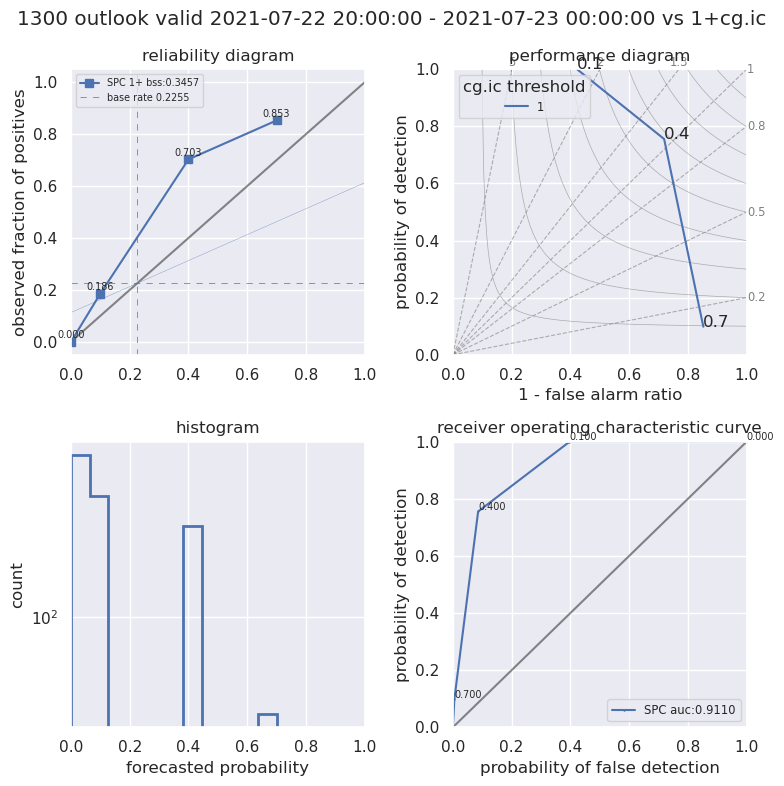

In [19]:
fig0 = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh=o_thresh,
    sep=0.01,
    n_bins=11,
    suptitle=f"{issue} outlook valid {valid_start} - {valid_end} vs {o_thresh}+{obsvar}",
)
ofile = tmpdir / "t.png"
fig0.savefig(ofile)
logging.warning(ofile)
fig0

## Verify dense neural network forecast

In [20]:
df = load_df(args)

# Put "valid_time", "y", and "x" in MultiIndex so we can group by them later.
# Used here and when calculating ensemble mean.
levels = ["initialization_time", "valid_time", "y", "x"]
df = df.set_index(levels)
feature_levels = ["forecast_hour", "lat", "lon"]
df = df.set_index(feature_levels, drop=False, append=True)
levels = levels + feature_levels

# make sure df label is same as obs (got earlier)
assert all(
    df[f"{obsvar}_{rptdist}km_{twin}hr"].xs(
        valid_start + pd.Timedelta(hours=twin / 2), level="valid_time"
    )
    == obs.values
)

2024-02-19 15:45:01,167 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021072200-0000.par 0.1G mtime Sat Dec 16 10:59:13 2023 240 features 8 labels and 4 index_cols & dropna.


In [21]:
savedmodel = get_savedmodel_path(args, odir="/glade/work/ahijevyc/NSC_objects/nn")
logging.warning(savedmodel)
ifold, thisfit = 0,0
savedmodel_thisfitfold = f"{savedmodel}_{thisfit}/{args.kfold}fold{ifold}"
model = load_model(savedmodel_thisfitfold)
model.summary()

2024-02-19 15:45:02,243 /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr


Model: "fit_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              246784    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 254984 (996.03 KB)
Trainable params: 254984 (996.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
index = pd.MultiIndex.from_product(
    [range(args.kfold), range(args.nfits)], names=["fold", "fit"]
)

Y = pd.concat([predct2(i, args, df) for i in index], keys=index, names=index.names)

2024-02-19 15:45:03,717 (0, 0) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_0/1fold0


6/6 [==============================] - 1s 51ms/step


2024-02-19 15:45:05,461 (0, 1) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_1/1fold0


6/6 [==============================] - 0s 48ms/step


2024-02-19 15:45:06,402 (0, 2) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_2/1fold0


6/6 [==============================] - 0s 48ms/step


2024-02-19 15:45:07,253 (0, 3) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_3/1fold0


6/6 [==============================] - 0s 48ms/step


2024-02-19 15:45:08,441 (0, 4) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_4/1fold0


6/6 [==============================] - 0s 65ms/step


In [28]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = Y.groupby(level=levels).mean()
assert (
    "fit" not in ensmean.index.names
), "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

dnntimes = pd.date_range(
    start=valid_start + pd.Timedelta(hours=twin / 2),
    end=valid_end - pd.Timedelta(hours=twin / 2),
    freq=f"{twin}h",
)

idx = pd.IndexSlice
ensmean = ensmean.loc[idx[:, dnntimes], :].xs("y_pred", axis="columns", level=0)
ensmean.groupby("valid_time").first().index

DatetimeIndex(['2021-07-22 22:00:00'], dtype='datetime64[us]', name='valid_time', freq=None)

2024-02-19 15:45:10,924 /glade/derecho/scratch/ahijevyc/tmp/t.png


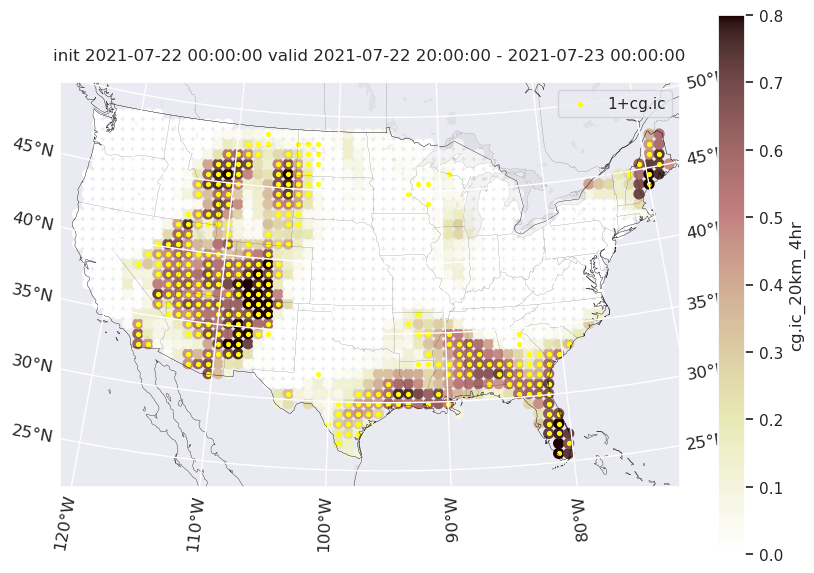

In [24]:
fig, ax = make_map(projection=map_crs)
f = f"{obsvar}_{rptdist}km_{twin}hr"
labels = (
    Y.groupby(level=levels)
    .mean()
    .loc[idx[:, dnntimes], :]
    .xs("y_label", axis="columns", level=0)
)

assert np.all(labels[f].values == obs)


def getp(ensmean):
    # probability of no occurences during long time window = product of 1-p for all
    # smaller time window pieces

    prob_none = (1 - ensmean).groupby(["y", "x"]).prod()
    # 1 minus prob_none = prob of at least one occurence.
    p = 1 - prob_none
    # add to df so we can use df's lat and lon for coordinates.
    p["lon"] = df.groupby(["y", "x"]).mean(numeric_only=True).lon
    p["lat"] = df.groupby(["y", "x"]).mean(numeric_only=True).lat
    return p


p = getp(ensmean)

p.plot(
    ax=ax,
    cmap="pink_r",
    c=f,
    kind="scatter",
    x="lon",
    y="lat",
    s=50,
    marker="o",
    transform=ccrs.PlateCarree(),
    vmax=0.8,
)
ax.set_title(f"init {args.idate} valid {valid_start} - {valid_end}")
ox = o.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    marker="o",
    markersize=3,
    color="yellow",
    label=f"{o_thresh}+{obsvar}",
    linewidths=2,
)
leg = ox.legend()
ofile = tmpdir / "t.png"
fig.savefig(ofile)
logging.warning(ofile)
fig

2024-02-19 15:49:19,317 /glade/derecho/scratch/ahijevyc/tmp/t.png


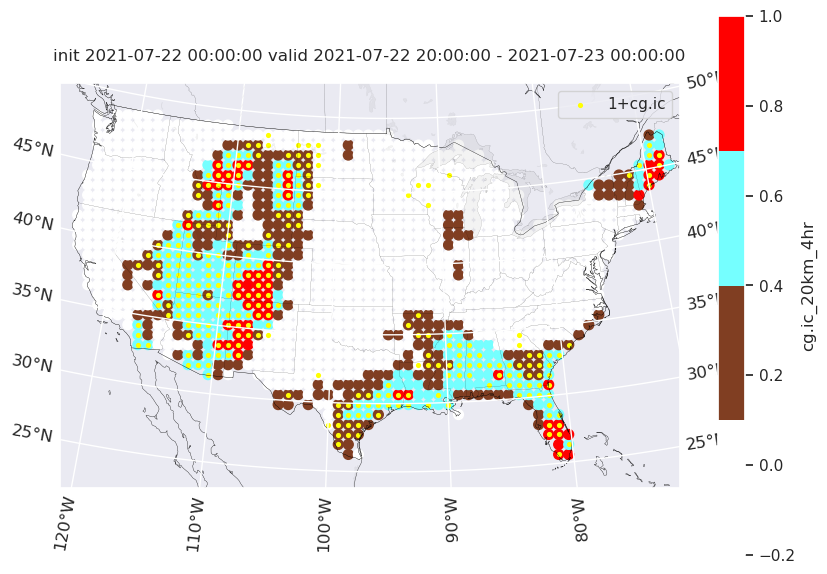

In [27]:
# 0-10-40-70
ensmean = ensmean.map(ztfs)

fig, ax = make_map(projection=map_crs)
p = getp(ensmean)

p.plot(
    ax=ax,
    cmap=enhtstm_cmap,
    c=f,
    norm=mpl.colors.Normalize(vmin=-0.2, vmax=1),
    kind="scatter",
    x="lon",
    y="lat",
    s=50,
    marker="o",
    transform=ccrs.PlateCarree(),
)
ax.set_title(f"init {args.idate} valid {valid_start} - {valid_end}")
ox = o.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    marker="o",
    markersize=3,
    color="yellow",
    label=f"{o_thresh}+{obsvar}",
    linewidths=2,
)
leg = ox.legend()
ofile = tmpdir / "t.png"
fig.savefig(ofile)
logging.warning(ofile)
fig

0.3433


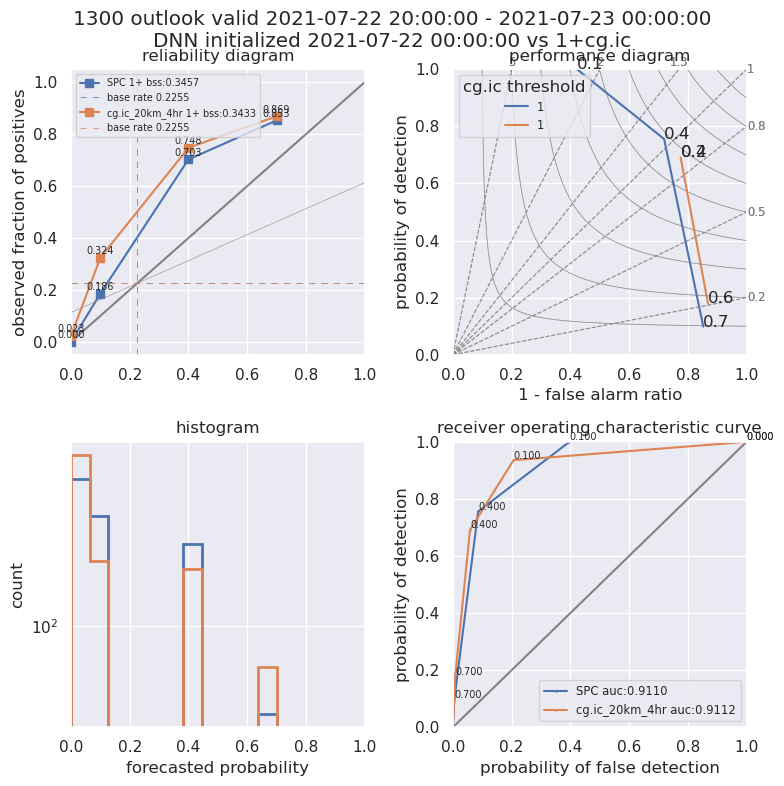

In [26]:
fcst = p[f]
pthresh = pd.Series(np.round(np.arange(0.2, 1, 0.2), 2), name=f"fcst\np thresh")

fig0 = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh=o_thresh,
    sep=0.15,
    n_bins=11,
    suptitle=(
        f"{issue} outlook valid {valid_start} - {valid_end}"
        f"\nDNN initialized {args.idate} vs {o_thresh}+{obsvar}"
    ),
    fig=fig0,
)

fig0.savefig(tmpdir / "t.png")
fig0